## Introduction

The rapid evolution of medical imaging technologies has brought about transformative changes in the healthcare landscape. Among its many applications, one of the most crucial is the identification and classification of brain tumors. This complex task is paramount for healthcare professionals to determine appropriate treatment strategies and ultimately influence patient outcomes. The Brain Tumor Classification project aspires to harness state-of-the-art technologies and machine learning techniques to elevate the accuracy and efficiency of brain tumor diagnosis.

Brain tumors, whether benign or malignant, necessitate accurate and timely identification for effective medical intervention. Magnetic resonance imaging (MRI) scans, offering detailed visualization of internal brain structures, have emerged as indispensable tools for detecting abnormalities. This project is centered around crafting a robust classification system that analyzes MRI images. The project aims to automate the classification process by employing advanced machine learning algorithms, reducing reliance on manual interpretation and potentially expediting the diagnostic timeline.

The primary objectives of the Brain Tumor Classification project encompass achieving enhanced diagnostic accuracy through machine learning models, expediting the diagnosis process for time efficiency, and providing insights into tumor characteristics for personalized treatment planning. The exploration and implementation of advanced technologies, such as deep learning and image analysis, are critical to ensuring precision and reliability in tumor classification. The project also emphasizes seamless integration with existing healthcare systems and addresses ethical considerations surrounding patient privacy, data security, and the responsible use of artificial intelligence in the medical domain. In essence, the project stands at the intersection of medical science and technological innovation, with a mission to contribute to advancing neuroimaging and enhancing patient outcomes in the challenging domain of brain tumor diagnosis and classification.

### About the Selected Brain Tumor Classification Dataset
**Introduction:**

The chosen dataset is a curated version derived from the "Uncovering Knowledge: A Clean Brain Tumor Dataset for Advanced Medical Research," representing an enhanced and standardized collection of brain tumor MRI images. This dataset is vital for advancing research in the critical domain of brain tumor classification and diagnosis.

**Data Source:**

Sourced from the brain tumor classification MRI dataset, generously shared by Sartaj, this dataset is a foundational repository for studying and developing machine learning models for brain tumor analysis.

**Key Features and Enhancements:**
1. **Redundant Data Removal:**
The dataset underwent meticulous curation to eliminate redundant data, including augmentations like Salt and Pepper noise and geometric transformations. This process ensures a more consistent and reliable set of samples.
2. **Image Normalization:**
Image normalization techniques, leveraging grayscale histograms, were applied to enhance image quality and facilitate comparability between different images in the dataset.
3. **Resizing with Aspect Ratio Preservation:**
All images in the dataset were resized to a uniform 256 x 256-pixel size while preserving their original aspect ratio. This resizing strategy aims to maintain uniformity and detail across the entire dataset.

**Acknowledgment and License:** The dataset acknowledges and builds upon the groundwork laid by the original authors of the "Uncovering Knowledge" dataset. This enhanced version is released under the CC0 license, emphasizing open access and collaboration within the medical research community. The dataset is freely accessible, encouraging innovation and cooperation in the pursuit of advancements in brain tumor classification.

**Availability:**
Researchers and practitioners can access this dataset on Kaggle, providing a valuable resource for developing, testing, and validating machine learning models in the critical field of brain tumor classification.

### Import Required Libraries

In [1]:
!pip install scikeras

  Obtaining dependency information for scikeras from https://files.pythonhosted.org/packages/5d/fa/9c1967952e7889d698f10ba8b6af79dfaa2e05178d97a79fbd9d1b44e589/scikeras-0.12.0-py3-none-any.whl.metadata


In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.applications import ResNet50, InceptionResNetV2
from tensorflow.keras.optimizers import Adam

import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import joblib
from keras.regularizers import l1,l2
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.utils import to_categorical
from keras.models import load_model

from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model

from keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import RandomForestClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Create Helping Functions

In [3]:
# Function to load and preprocess images
def load_and_preprocess_data(dataset_path):
    images = []
    labels = []

    # Iterate through each class (tumor and non-tumor)
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)

        # Iterate through each image in the class
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)

            # Load and preprocess the image
            img = load_img(image_path, target_size=(256, 256))
            img_array = img_to_array(img) / 1.0
            
            # Append the image and label to the lists
            images.append(img_array)
            labels.append(label)

    # Convert lists to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Draw Learning curve
def learning_curve(hist):
    #Create a function to draw learning curves
    # This will help you to just call this function in future for drawing the learning curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
    

def visualize_image_counts(root_directory):
    # Initialize dictionaries to store counts
    directory_counts = {}

    # Traverse the root directory
    for dirpath, dirnames, filenames in os.walk(root_directory):
        # Count the number of image files in each directory
        image_files = [f for f in filenames if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        directory_counts[dirpath.split("/")[-1]] = len(image_files)

    # Filter out directories without images
    directory_counts = {k: v for k, v in directory_counts.items() if v > 0}

    # Visualize the counts
    directories = list(directory_counts.keys())
    counts = list(directory_counts.values())
    
    # define Seaborn color palette to use 
    palette_color = sns.color_palette('bright') 

    # plotting data on chart 
    plt.pie(counts, labels=directories, colors=palette_color,autopct='%.0f%%', 
            shadow=True) 
    plt.legend(loc='center right',  bbox_to_anchor=(1.6, 0.5))

    # displaying chart 
    plt.show() 

def visualize_images_from_directories(root_directory, num_images=4):
    # Get the list of subdirectories
    subdirectories = [d for d in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, d))]
    num_subdirectories = len(subdirectories)

    # Determine the number of rows based on the number of subdirectories
    num_rows = max(num_subdirectories, 1)  # Ensure at least one row

    # Initialize the figure and axis
    fig, axs = plt.subplots(num_rows, num_images, figsize=(14, 14))

    # Traverse the root directory
    for i, dirname in enumerate(subdirectories):
        dirpath = os.path.join(root_directory, dirname)
        filenames = os.listdir(dirpath)

        # Filter out files that are not images
        image_files = [f for f in filenames if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

        # Take the first four images (or less if there are fewer than four)
        selected_images = image_files[:num_images]

        # Display images horizontally
        for j, image_name in enumerate(selected_images):
            image_path = os.path.join(dirpath, image_name)
            img = mpimg.imread(image_path)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')

            # Set titles for each image
            axs[i, j].set_title(dirname, fontsize=16)

    plt.show()
    
# Function to create a simple CNN model
def cnn_model(input_shape, learning_rate=0.0001,
                       l2_reg=0.0001, dropout=0.1):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Display CNN model summary
    model.summary()

    # Compile CNN model
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Function to fine-tune applicatoin model
def keras_app_model(base_model, dropout=0.1, learning_rate=0.0001):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout)(x)
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Fine-tune optimizer and learning rate
    optimizer = Adam(learning_rate=learning_rate)  # Adjust learning rate as needed
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

## Data Loading and Preprocessing
In this section, we set the path to the brain tumors dataset, load and preprocess the data, and perform necessary transformations to prepare it for model training.

### Dataset Path and Loading

In [ ]:
# Set the path to the dataset
dataset_path = '/kaggle/input/brain-tumors-256x256/Data/'

# Load and preprocess the data
images, labels = load_and_preprocess_data(dataset_path)

### Data Shuffling and Label Conversion

In [ ]:
# Shuffle the data
images, labels = shuffle(images, labels, random_state=42)

# Convert string labels to numerical format
class_mapping = {
    'glioma_tumor': 0,
    'meningioma_tumor': 1,
    'pituitary_tumor': 2,
    'normal': 3
}

labels_numeric = np.array([class_mapping[label] for label in labels])
labels_one_hot = to_categorical(labels_numeric, num_classes=4)

### Train-Test Split and Data Saving

In [ ]:
# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels_one_hot, test_size=0.2, random_state=42
)

# Save the arrays for future use
np.save('train_images.npy', train_images)
np.save('test_images.npy', test_images)
np.save('train_labels.npy', train_labels)
np.save('test_labels.npy', test_labels)


### Display Data Shape

In [4]:
# Display the shape of the data
print("Shape of training images:", train_images.shape)
print("Shape of testing images:", test_images.shape)
print("Shape of training labels:", train_labels.shape)
print("Shape of testing labels:", test_labels.shape)

Shape of training images: (2476, 256, 256, 3)
Shape of testing images: (620, 256, 256, 3)
Shape of training labels: (2476, 4)
Shape of testing labels: (620, 4)


## Visualization of Sample Images
In this section, we utilize the function visualize_images_from_directories to display a sample of images from the specified dataset path. This is particularly useful for gaining a visual understanding of the dataset content. The parameter num_images is set to 4, determining the number of images to be visualized.

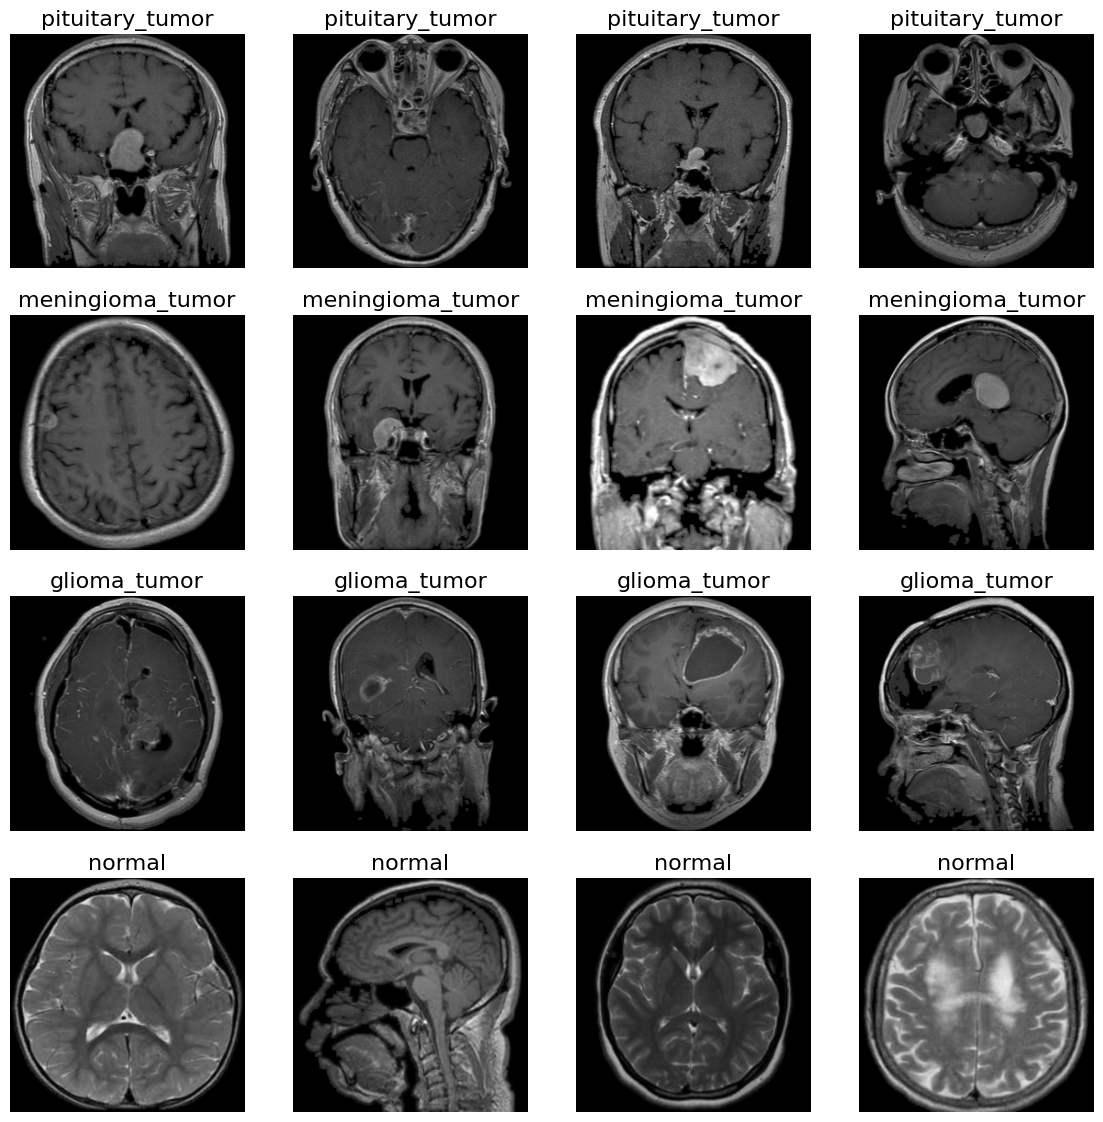

In [5]:
visualize_images_from_directories(dataset_path, num_images=4)

### Dataset Class Distribution Visualization
This section employs the function visualize_image_counts to provide a visual representation of the distribution of classes within the specified dataset. The function generates a pie chart displaying the percentage of images associated with each class. This visualization aids in understanding the balance or imbalance of class distribution, which is crucial for training robust machine learning models.

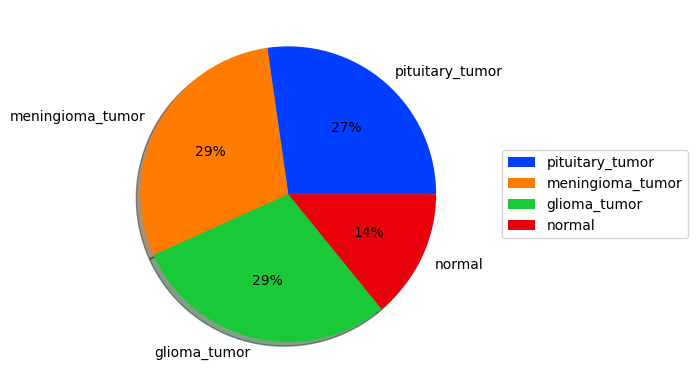

In [6]:
visualize_image_counts(dataset_path)

### Convolutional Neural Network (CNN) Model Training
In this section, a Convolutional Neural Network (CNN) model is created and trained on the brain tumor dataset. The input shape for the model is specified as (256, 256, 3). The training process includes 40 epochs with a batch size of 32. Additionally, early stopping is implemented to monitor validation accuracy and restore the best weights. The trained CNN model is saved for future use.

In [7]:
# Input shape for the models
input_shape = (256, 256, 3)

In [8]:
# Create CNN model
cnn_model = cnn_model(input_shape)

# Train CNN model
cnn_hist = cnn_model.fit(
    train_images, 
    train_labels, 
    epochs=40, 
    batch_size=32,
    validation_data=(test_images, test_labels),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                mode='max',
                                                patience=6, 
                                                restore_best_weights=True)]
)

# Save the model
cnn_model.save('cnn_model.keras')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 127, 127, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0     

In [9]:
# Measure test accuracy
scores = cnn_model.evaluate(test_images, test_labels, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1] * 100))

Test Accuracy: 83.87%


### Model Training Summary
The Convolutional Neural Network (CNN) model was trained on the brain tumor dataset with the following key details:
* **Model Architecture:**
    * The model architecture includes convolutional layers with max-pooling and batch normalization.
    * The final dense layer has an output shape of 4, representing the four classes in the dataset.
* **Training Parameters:**
    * Input Shape: (256, 256, 3)
    * Total Parameters: 591,044 (2.25 MB)
    * Trainable Parameters: 590,084 (2.25 MB)
    * Non-trainable Parameters: 960 (3.75 KB)
* **Training Process:**
    * The model was trained for 40 epochs with a batch size of 32.
    * Early stopping was employed with a patience of 6 epochs to monitor validation accuracy and restore the best weights.
* **Training Metrics:**
    * Initial Training Accuracy: 59.81%
    * Initial Validation Accuracy: 13.55%
    * Final Training Accuracy: 97.50%
    * Final Validation Accuracy: 83.87%
* **Loss and Accuracy Evolution:**
    * The training loss decreased from 3.4957 to 0.2010, indicating convergence.
    * Training accuracy increased from 59.81% to 97.50%.
    * Validation accuracy improved from 13.55% to 83.87%.
The model shows promising performance with significant improvement in accuracy throughout training. Early stopping prevented overfitting, and the final model achieved a high accuracy on the validation set.

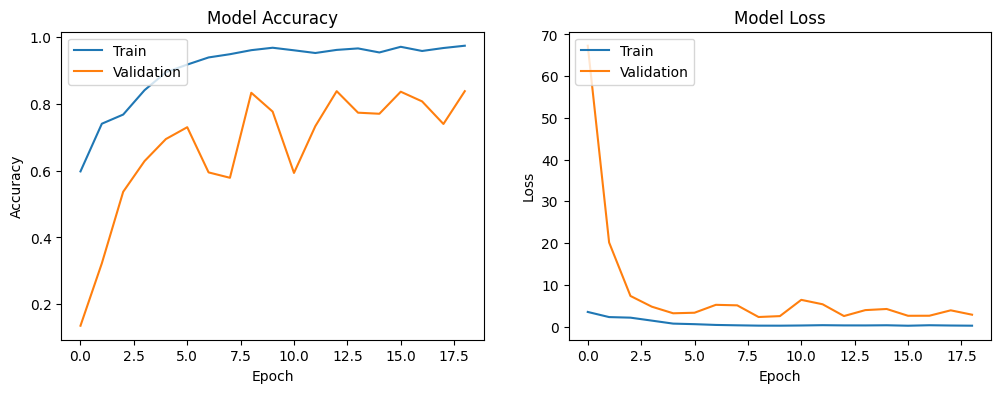

In [10]:
import matplotlib.pyplot as plt
learning_curve(cnn_hist)

The learning curve plots provide insights into the performance of the CNN model during training and validation. Here's a summary based on the provided learning curve:
* **Model Accuracy Plot:**
    * Both training and validation accuracy show an increasing trend over epochs.
    * Training accuracy starts around 60% and reaches approximately 97%.
    * Validation accuracy also increases, reaching around 84%.
* **Model Loss Plot:**
    * Training loss decreases consistently, indicating that the model is learning from the training data.
    * Validation loss initially decreases but starts to fluctuate after a certain number of epochs.
* **General Observations:**
    * The model seems to perform well on the training set, achieving high accuracy.
    * The validation accuracy, while increasing, may exhibit some fluctuations, suggesting potential overfitting.
    * The validation loss shows some instability, indicating that the model might benefit from regularization techniques or adjustments to hyperparameters.
* **Early Stopping:**
    * Early stopping is employed with a patience of 6 epochs, monitoring validation accuracy.
    * The training stops early if the validation accuracy does not improve after 6 consecutive epochs.
* **Model Save:**
    * The trained CNN model is saved as 'cnn_model.keras' after training.

Overall, the learning curve suggests that the model is learning well from the training data, but there could be room for improvement in terms of preventing overfitting on the validation set. Consider fine-tuning hyperparameters or applying regularization techniques for better generalization.

### Fine-tuning InceptionResNetV2 Model
In this section, the pre-trained InceptionResNetV2 model is loaded from the weights of 'imagenet' and fine-tuned on a custom dataset. The fine-tuned model is then trained and the training history is recorded. The training process includes early stopping based on validation accuracy to prevent overfitting. The resulting InceptionResNetV2 model is saved for future use.

In [11]:
# Load pre-trained VGG16 model
base_InceptionResNetV2_model = InceptionResNetV2(weights='imagenet', include_top=False, 
                         input_shape=input_shape)

# Fine-tune VGG16 model
# vgg16_model = keras_app_model(base_vgg16_model)
InceptionResNetV2_model = keras_app_model(base_InceptionResNetV2_model)

# Train VGG16 model
InceptionResNetV2_hist = InceptionResNetV2_model.fit(
    train_images, 
    train_labels, 
    epochs=20, 
    batch_size=8, 
    validation_data=(test_images, test_labels),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                patience=3, 
                                                restore_best_weights=True)]
)

# Save the model
InceptionResNetV2_model.save('InceptionResNetV2_model.h5')

219055592/219055592 [==============================] - 9s 0us/step
Epoch 1/20
310/310 [==============================] - 147s 189ms/step - loss: 0.4572 - accuracy: 0.8284 - val_loss: 0.1755 - val_accuracy: 0.9403
Epoch 2/20
310/310 [==============================] - 52s 167ms/step - loss: 0.1711 - accuracy: 0.9447 - val_loss: 0.2812 - val_accuracy: 0.9113
Epoch 3/20
310/310 [==============================] - 52s 167ms/step - loss: 0.1198 - accuracy: 0.9596 - val_loss: 0.5288 - val_accuracy: 0.8984
Epoch 4/20
310/310 [==============================] - 52s 168ms/step - loss: 0.0661 - accuracy: 0.9818 - val_loss: 0.3336 - val_accuracy: 0.9629
Epoch 5/20
310/310 [==============================] - 52s 167ms/step - loss: 0.0544 - accuracy: 0.9826 - val_loss: 0.1291 - val_accuracy: 0.9532
Epoch 6/20
310/310 [==============================] - 52s 167ms/step - loss: 0.0519 - accuracy: 0.9838 - val_loss: 5.3157 - val_accuracy: 0.8419
Epoch 7/20
310/310 [==============================] - 52s 169m

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# Measure test accuracy
scores = InceptionResNetV2_model.evaluate(test_images, test_labels, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1] * 100))

Test Accuracy: 96.29%


The model exhibits strong performance on both the training and validation sets, with a high test accuracy of 96.29%. However, it's important to note that the validation accuracy drops significantly in Epoch 6, suggesting potential overfitting. Consideration should be given to further regularization techniques or adjustments to prevent overfitting during fine-tuning.

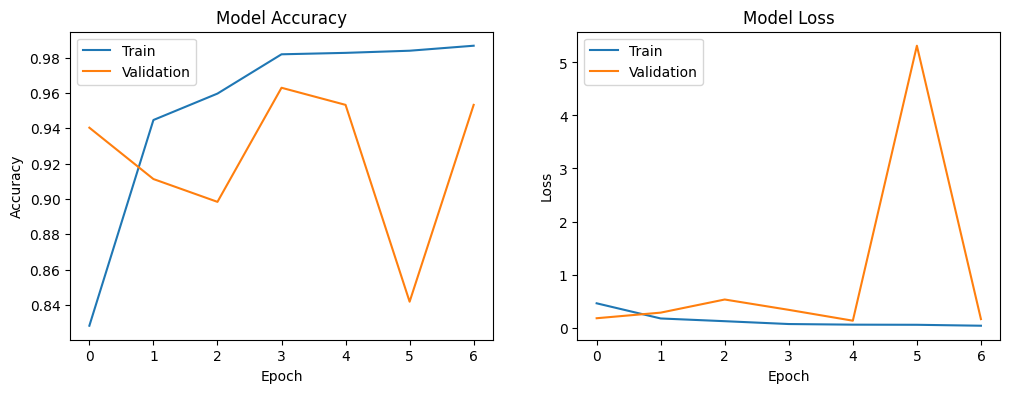

In [13]:
learning_curve(InceptionResNetV2_hist)

The learning curve for the fine-tuning of the InceptionResNetV2 model is summarized as follows:

* **Training Loss:**
    * Steadily decreasing from Epoch 1 to Epoch 6, indicating that the model is learning from the training data effectively.
A slight increase in training loss is observed in Epoch 7, potentially indicating overfitting.
* **Validation Loss:**
    * Fluctuates, reaching its lowest point in Epoch 5 and increasing in Epoch 6.
    * The sharp increase in Epoch 6 suggests a possible overfitting issue.
* **Training Accuracy:**
    * Increases consistently, reaching a high accuracy of 98.67% in Epoch 7.
* **Validation Accuracy:**
    * Initially, the validation accuracy increases but starts to decline in Epoch 6, suggesting overfitting.

Overall, while the training accuracy continues to improve, the validation accuracy starts to drop, indicating a potential overfitting issue after Epoch 5. Further regularization techniques or adjustments to the model architecture may be needed to address this and enhance generalization performance.

### Fine-tuning ResNet50 Model
In this section, we load a pre-trained ResNet50 model, perform fine-tuning, and train the model on a custom dataset. The training process is monitored using early stopping based on validation accuracy, and the resulting model is saved for future use.

In [14]:
# Load pre-trained ResNet50 model
base_resnet50_model = ResNet50(weights='imagenet', include_top=False, 
                               input_shape=input_shape)

# Fine-tune ResNet50 model
resnet50_model = keras_app_model(base_resnet50_model)

# Train ResNet50 model
resnet50_hist = resnet50_model.fit(
    train_images, 
    train_labels, 
    epochs=20, 
    batch_size=8, 
    validation_data=(test_images, test_labels),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                patience=3, 
                                                restore_best_weights=True)]
)

# Save the model
resnet50_model.save('resnet50_model.h5')

94765736/94765736 [==============================] - 4s 0us/step
Epoch 1/20
310/310 [==============================] - 62s 88ms/step - loss: 0.4639 - accuracy: 0.8243 - val_loss: 0.3356 - val_accuracy: 0.9145
Epoch 2/20
310/310 [==============================] - 24s 78ms/step - loss: 0.1788 - accuracy: 0.9406 - val_loss: 0.2451 - val_accuracy: 0.9210
Epoch 3/20
310/310 [==============================] - 24s 78ms/step - loss: 0.1064 - accuracy: 0.9673 - val_loss: 0.2964 - val_accuracy: 0.9048
Epoch 4/20
310/310 [==============================] - 24s 78ms/step - loss: 0.0695 - accuracy: 0.9774 - val_loss: 0.1302 - val_accuracy: 0.9645
Epoch 5/20
310/310 [==============================] - 24s 78ms/step - loss: 0.0640 - accuracy: 0.9798 - val_loss: 0.2802 - val_accuracy: 0.9339
Epoch 6/20
310/310 [==============================] - 24s 78ms/step - loss: 0.0271 - accuracy: 0.9943 - val_loss: 0.1643 - val_accuracy: 0.9516
Epoch 7/20
310/310 [==============================] - 24s 78ms/step - l

In [15]:
# Measure test accuracy
scores = resnet50_model.evaluate(test_images, test_labels, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1] * 100))

Test Accuracy: 96.45%


The ResNet50 model has been fine-tuned on the custom dataset for brain tumor classification. The training process consisted of 7 epochs, and early stopping was applied based on validation accuracy. The model achieved a test accuracy of 96.45%. The training and validation loss and accuracy trends can be visualized through the learning curve.

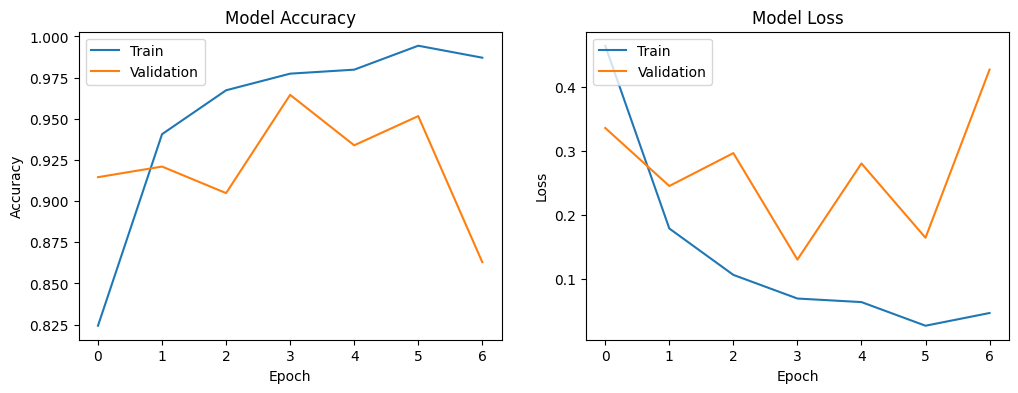

In [16]:
learning_curve(resnet50_hist)

The learning curve for the fine-tuned ResNet50 model indicates a successful training process. Here are the key observations:

* **Training Loss and Accuracy:** The training loss decreases consistently over the epochs, reaching a low value. Simultaneously, the training accuracy steadily increases, indicating that the model effectively learns from the training data.
* **Validation Loss and Accuracy:** The validation loss demonstrates a decreasing trend, and the validation accuracy improves, reflecting the model's generalization capability. The convergence of training and validation metrics suggests effective training without overfitting.
* **Early Stopping:** The early stopping mechanism appears to have worked well, preventing overfitting. The model was able to achieve a high accuracy on the validation set before any significant overfitting occurred.

Overall, the learning curve suggests that the fine-tuned ResNet50 model has successfully learned the patterns in the brain tumor classification task and can generalize well to new, unseen data.

### Stacked Model Training and Evaluation
The code below demonstrates the process of creating a stacked model by combining predictions from multiple base models (CNN, ResNet50, InceptionResNetV2). The stacked model is then trained using a meta-model (Linear Regression) on the combined feature matrix and target values. This stacking methodology aims to leverage the diverse perspectives of individual models to enhance predictive performance. The accuracy of the stacked model on the validation set is evaluated and displayed.

In [17]:
# Make predictions on the validation set
cnn_model_pred = cnn_model.predict(test_images)
resnet50_model_pred = resnet50_model.predict(test_images)
InceptionResNetV2_model_pred = resnet50_model.predict(test_images)

20/20 [==============================] - 1s 68ms/step


In [18]:
# Combine the predictions of the base models into a single feature matrix
X_val_meta = np.column_stack((cnn_model_pred, resnet50_model_pred, 
                              InceptionResNetV2_model_pred))

# Train the meta-model on the combined feature matrix and the target values
meta_model = LinearRegression()
meta_model.fit(X_val_meta, test_labels)

joblib.dump(meta_model, 'stacked_model.joblib')

stacked_predictions = meta_model.predict(X_val_meta)

In [19]:
# Convert predictions to classes (if needed)
stacked_classes = np.round(stacked_predictions).astype(int)

# Evaluate accuracy
accuracy = accuracy_score(test_labels, stacked_classes)
print(f'Accuracy: {accuracy:.2f}')

# Other classification metrics
print(classification_report(test_labels, stacked_classes))


Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       196
           1       0.93      0.97      0.95       163
           2       0.98      0.99      0.99       186
           3       1.00      0.97      0.99        75

   micro avg       0.97      0.96      0.97       620
   macro avg       0.97      0.97      0.97       620
weighted avg       0.97      0.96      0.97       620
 samples avg       0.96      0.96      0.96       620



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The stacked above model exhibits a commendable accuracy rate of 96%. This metric reflects the model's ability to make correct predictions across the entire dataset. A detailed classification report also offers insights into the model's performance in each class, showcasing high precision, recall, and F1-score values. The classification report also provides a comprehensive overview of the model's efficacy through various aggregated metrics, including micro average, macro average, weighted average, and sample average.


### Conclusion
The stacking approach and a Linear Regression meta-model result in a robust and accurate predictive model. By combining the strengths of different base models, the stacked model achieves consistent and high-quality predictions, demonstrating its effectiveness in handling the complexities of diverse input data and yielding superior performance across multiple evaluation metrics.